# Gradient boosting - definicja

In [75]:
from sklearn.tree import DecisionTreeRegressor


class GradientBoostingRegressorCust:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        y_pred = np.full(y.shape, np.mean(y))
        for _ in range(self.n_estimators):
            residuals = y - y_pred
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            self.trees.append(tree)

    def predict(self, X):
        y_pred = np.full((X.shape[0],), 0.0)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


# Ada boost - definicja

In [76]:
class AdaBoostRegressorCust:
    def __init__(self, n_estimators=100, learning_rate=1.0, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        w_i = np.ones(n_samples) / n_samples
        self.models = []

        for _ in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, y, sample_weight=w_i)
            pred = tree.predict(X)
            error = np.abs(y - pred)
            r_i = error / (np.max(error))
            e_k = np.sum(w_i * r_i)
            beta = e_k / (1 - e_k)

            w_i *= beta ** (self.learning_rate * (1 - r_i))
            w_i /= np.sum(w_i)

            self.models.append(tree)

    def predict(self, X):
        preds = np.zeros(X.shape[0])
        for model in self.models:
            preds += model.predict(X)
        return preds / self.n_estimators


# Predykcja na małym, średnim i dużym zbiorze danych - wybór zbiorów danych

In [77]:
#mały zbiór
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

In [78]:
#zbiór średniej wielkości
import pandas as pd

wine = pd.read_csv("/Users/mariadeka/Downloads/wine+quality/winequality-white.csv", sep=';')

In [79]:
#duży zbiór
diamonds = pd.read_csv("/Users/mariadeka/Downloads/diamonds.csv")

# Analiza eksperymentalna

Analiza dla zbioru danych Diabetes

In [80]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = diabetes.data
y = diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.01, 0.2, 0.4, 0.6, 0.8, 1]
n_estimators_list = [10, 50, 90, 130, 170]
max_depths = [1, 2, 3, 4, 5, 6, 7]

results = []

for lr in learning_rates:
    for n_estimators in n_estimators_list:
        for max_depth in max_depths:
            start_time = time.time()
            model = GradientBoostingRegressorCust(
                learning_rate=lr,
                n_estimators=n_estimators,
                max_depth=max_depth
            )

            model.fit(X_train, y_train)

            training_time = time.time() - start_time

            start_pred_time = time.time()
            y_pred = model.predict(X_test)
            prediction_time = time.time() - start_pred_time

            mse = mean_squared_error(y_test, y_pred)

            results.append({
                'learning_rate': lr,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'MSE': mse,
                'training_time': training_time,
                'prediction_time': prediction_time
            })

results_diabetes = pd.DataFrame(results)
print(results_diabetes)


     learning_rate  n_estimators  max_depth           MSE  training_time  \
0             0.01            10          1  26388.179225       0.011116   
1             0.01            10          2  26271.489950       0.005237   
2             0.01            10          3  26333.086032       0.006553   
3             0.01            10          4  26374.662342       0.007860   
4             0.01            10          5  26306.515358       0.009164   
..             ...           ...        ...           ...            ...   
205           1.00           170          3  33294.078049       0.102687   
206           1.00           170          4  28914.762458       0.126386   
207           1.00           170          5  28916.531665       0.137543   
208           1.00           170          6  29215.844229       0.107982   
209           1.00           170          7  29667.552617       0.086887   

     prediction_time  
0           0.000934  
1           0.000491  
2           0.0004

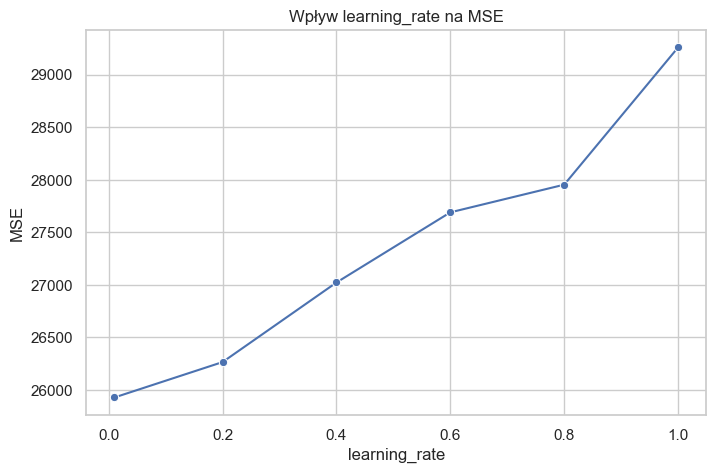

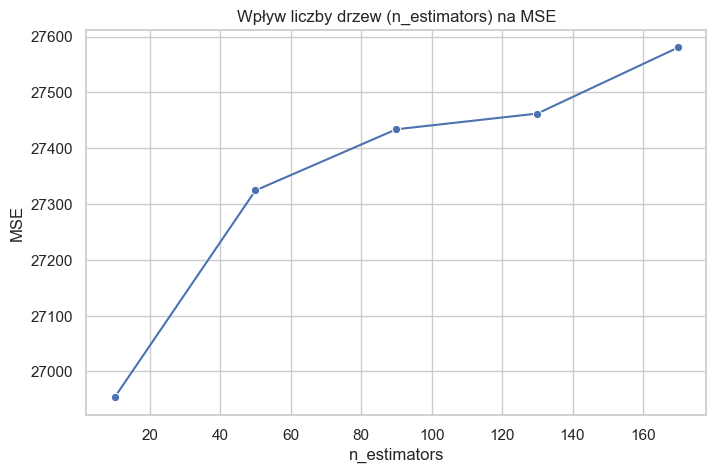

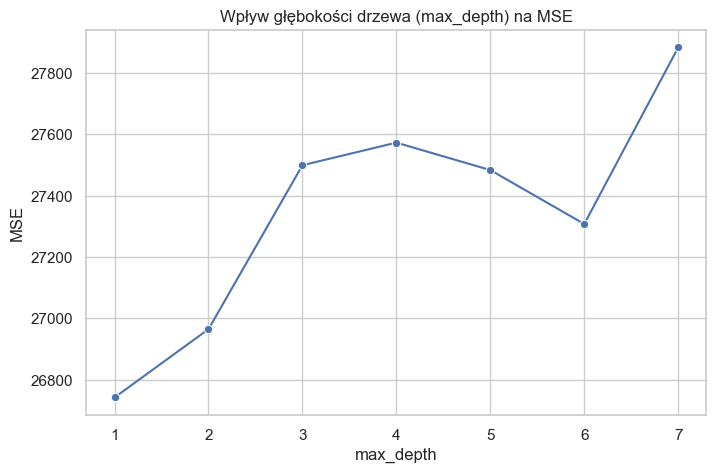

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# learning_rate vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes, x="learning_rate", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na MSE")
plt.xlabel("learning_rate")
plt.ylabel("MSE")
plt.show()

# n_estimators vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes, x="n_estimators", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na MSE")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.show()

# max_depth vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes, x="max_depth", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na MSE")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()


Wnioski:
1. Błąd MSE rośnie wraz ze zwiększaniem n_estimators oraz learning_rate. Może to świadczyć o tendencji do przeuczania się modelu.
2. W ogólności błąd MSE rośnie wraz ze zwiększaniem głębokości drzewa (z niewielkim wyjątkiem dla wartości max_depth = 5 i max_depth=6). To, jak i również znacząca zmiana wartości MSE z punktu max_depth = 6 do max_depth=7 może sugerować, że model ma tendencję do przeuczania się.

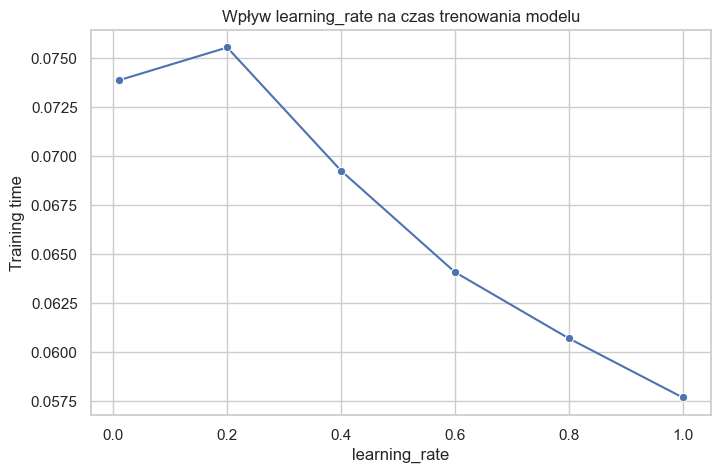

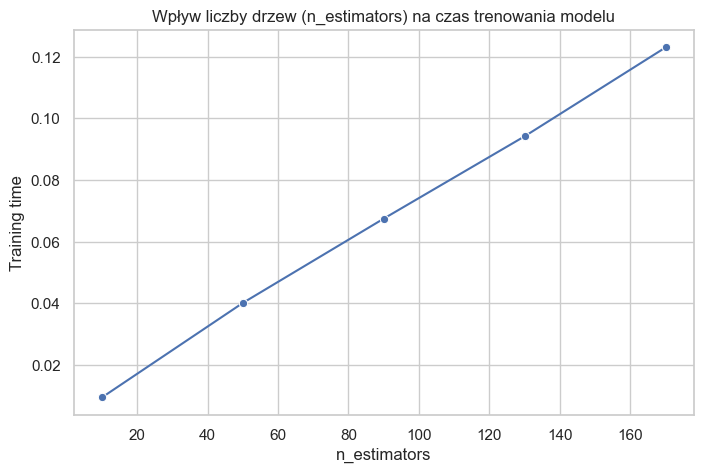

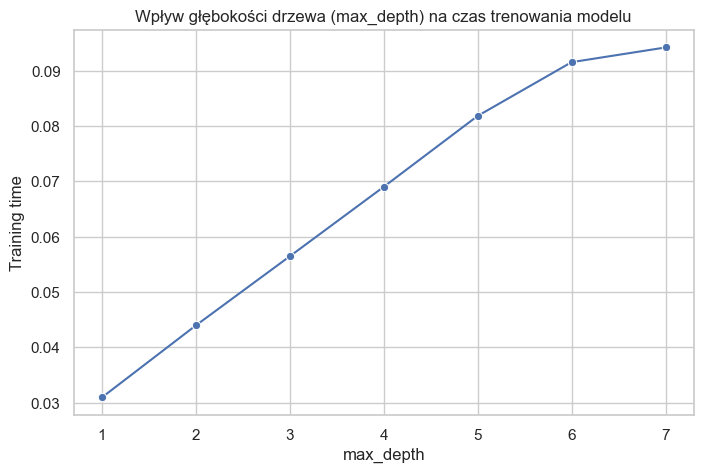

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# learning_rate vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes, x="learning_rate", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na czas trenowania modelu")
plt.xlabel("learning_rate")
plt.ylabel("Training time")
plt.show()

# n_estimators vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes, x="n_estimators", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na czas trenowania modelu")
plt.xlabel("n_estimators")
plt.ylabel("Training time")
plt.show()

# max_depth vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes, x="max_depth", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na czas trenowania modelu")
plt.xlabel("max_depth")
plt.ylabel("Training time")
plt.show()


Wnioski:
1. Dla learning_rate 0.2 czas trenowania modelu jest nieco dłuższy niż dla learning_rate = 0.01, jednak dla wartości wyższych niż 0.2 Czas trenowania modelu spada wraz ze wzrostem parametry learning_rate.
2. Wzrost czasu trenowania modelu, względem wzrostu parametru n_estimators jest zbliżony do liniowego. Analogiczny wniosek można wyciągnąć z analizy wzrostu czasu trenowania modelu względem wzrostu marametru max_depth, jednak tutaj dla wartości max_depth większej od 5 wykres ten zaczyna się wypłaszczać. Na tej podstawie możemy sądzić, że nie każde drzewo będzie osiągało swoją maksymalną głębokość (6 lub 7).

Analiza dla zbioru danych Wine Quality

In [83]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

full_data = wine
X = full_data.drop('quality', axis=1)
y = full_data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.01, 0.2, 0.4, 0.6, 0.8, 1]
n_estimators_list = [10, 50, 90, 130, 170]
max_depths = [1, 2, 3, 4, 5, 6, 7]

results = []

for lr in learning_rates:
    for n_estimators in n_estimators_list:
        for max_depth in max_depths:
            start_time = time.time()

            model = GradientBoostingRegressorCust(
                learning_rate=lr,
                n_estimators=n_estimators,
                max_depth=max_depth,
            )

            model.fit(X_train, y_train)

            training_time = time.time() - start_time

            start_pred_time = time.time()
            y_pred = model.predict(X_test)
            prediction_time = time.time() - start_pred_time

            mse = mean_squared_error(y_test, y_pred)

            results.append({
                'learning_rate': lr,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'MSE': mse,
                'training_time': training_time,
                'prediction_time': prediction_time
            })

results_wine = pd.DataFrame(results)
print(results_wine)

     learning_rate  n_estimators  max_depth        MSE  training_time  \
0             0.01            10          1  35.601473       0.023461   
1             0.01            10          2  35.574978       0.035620   
2             0.01            10          3  35.558752       0.048665   
3             0.01            10          4  35.559970       0.063463   
4             0.01            10          5  35.557866       0.078339   
..             ...           ...        ...        ...            ...   
205           1.00           170          3  34.922813       0.828860   
206           1.00           170          4  34.717970       1.070802   
207           1.00           170          5  34.905015       1.315313   
208           1.00           170          6  34.749089       1.560139   
209           1.00           170          7  34.992682       1.807878   

     prediction_time  
0           0.002635  
1           0.002465  
2           0.002464  
3           0.002493  
4       

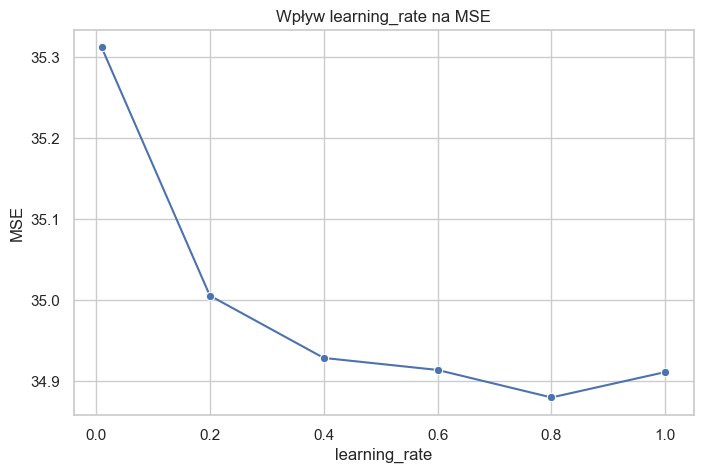

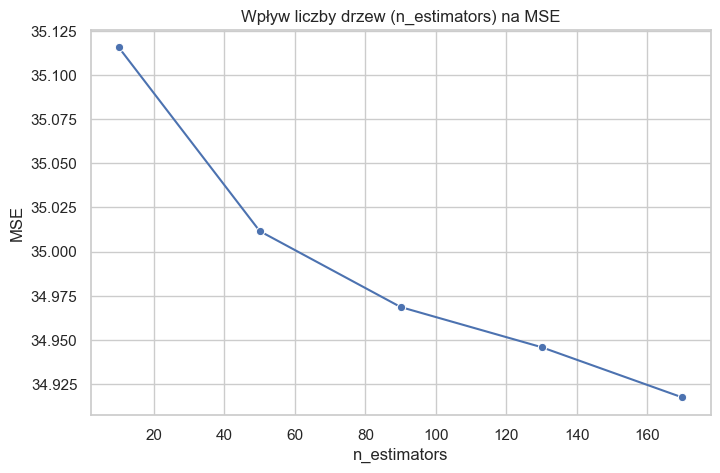

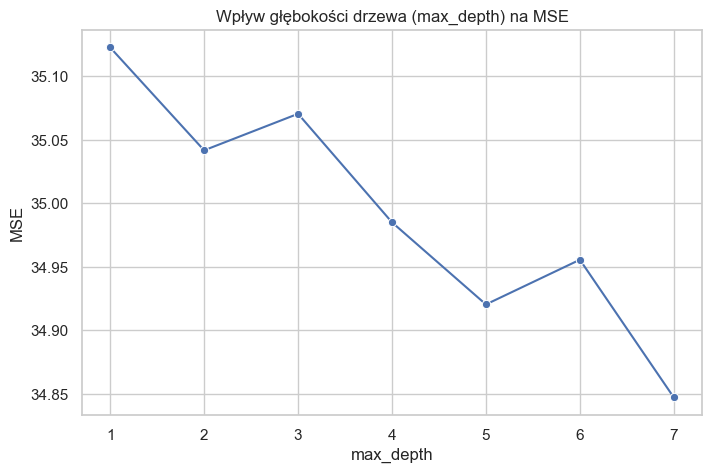

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

#learning rate vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine, x="learning_rate", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na MSE")
plt.xlabel("learning_rate")
plt.ylabel("MSE")
plt.show()

#n_estimators vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine, x="n_estimators", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na MSE")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.show()

#max depth vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine, x="max_depth", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na MSE")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()

Wniosek: W ogólności możemy stwierdzić, że błąd MSE maleje wraz ze wzrostem poszczególnych parametrów (learning_rate, n_estimators, max_depth). Możemy na tej podstawie stwierdzić, że model działa lepiej dla wyższych wartości owych parametrów. Obserwacja ta (dla zbioru danych wine quality) jest odwrotna od wniosku który wyciągnęłam z analizy działania modelu na zbiorze danych diabetes. Prawdopodobnym powodem takiej zmiany jest to, że w mniejszym zbiorze danych (diabetes) model miał tendencję do przeuczania się, jednak już na większym zbiorze, jakim jest wine quality model będzie działał lepiej dla wyższych parametrów.
Zwiększenie parametru max_depth, który odpowiada za definiowanie maksymalnej głębokości pojedynczego drzewa, powoduj lepsze dopasowywanie się modelu do danych, co w ogólności nie będzie powodowała przeuczenia się modelu, ze względu na jego dużą ilość próbek.

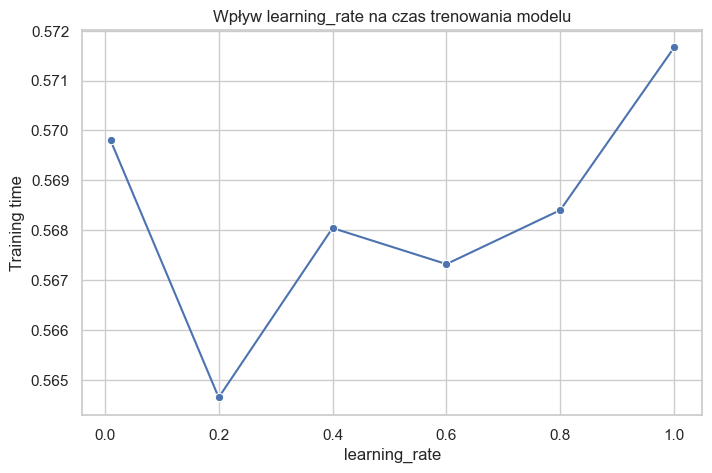

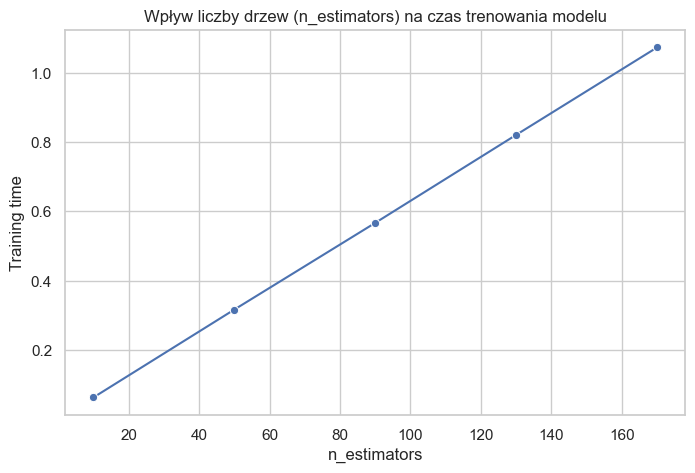

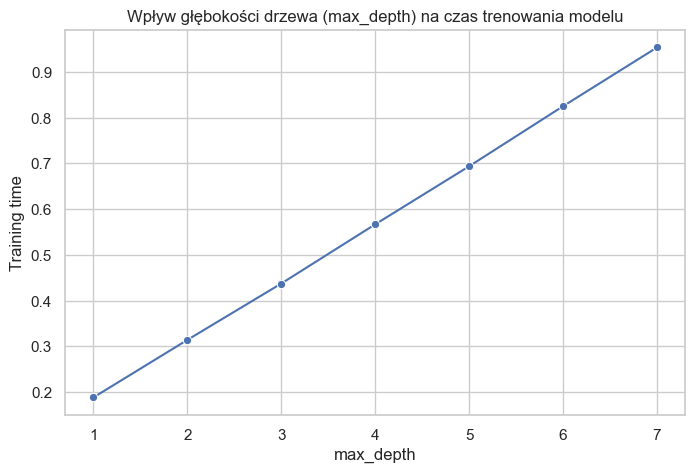

In [110]:
#learning rate vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine, x="learning_rate", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na czas trenowania modelu")
plt.xlabel("learning_rate")
plt.ylabel("Training time")
plt.show()

#n_estimators vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine, x="n_estimators", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na czas trenowania modelu")
plt.xlabel("n_estimators")
plt.ylabel("Training time")
plt.show()

#max depth vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine, x="max_depth", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na czas trenowania modelu")
plt.xlabel("max_depth")
plt.ylabel("Training time")
plt.show()

Wnioski:
1. Czas trenowania modelu jest niższy dla parametru learning_rate=0.2 niż dla wartości learning_rate=0.01. Może to wynikać z szybszej konwergencji przy umiarkowanym tempie uczenia. Przy dalszym wzroście parametru learning_rate czas uczenia zaczyna rosnąć.
2. Czas trenowania modelu wzrasta liniowo w zależności od wzrostu parametru n_estimators. Analogiczną zależność obserwuję przy badaniu zależności od parametru max_depth.

Analiza zbioru danych diamonds

In [86]:
#usunęłam kolumny, które były w większości wypełnione wartością "unknown"
diam = diamonds.drop(
    ['fancy_color_intensity', 'fancy_color_overtone', 'fancy_color_secondary_color', 'fancy_color_dominant_color',
     'fluor_color', 'fluor_intensity', 'girdle_max', 'girdle_min', 'culet_condition', 'culet_size', 'eye_clean',
     'cut_quality'], axis=1)

In [87]:
diam = pd.get_dummies(diam)
diam = diam[diam['color_unknown'] != True]

In [88]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

full_data = diam
X = full_data.drop('total_sales_price', axis=1)
X = X.astype(int)
y = full_data['total_sales_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.01, 0.1, 0.5, 1]
n_estimators_list = [50, 100, 200]
max_depths = [3, 5, 7]

results = []

for lr in learning_rates:
    for n_estimators in n_estimators_list:
        for max_depth in max_depths:
            start_time = time.time()

            model = GradientBoostingRegressorCust(
                learning_rate=lr,
                n_estimators=n_estimators,
                max_depth=max_depth
            )

            model.fit(X_train, y_train)

            training_time = time.time() - start_time

            start_pred_time = time.time()
            y_pred = model.predict(X_test)
            prediction_time = time.time() - start_pred_time

            mse = mean_squared_error(y_test, y_pred)

            results.append({
                'learning_rate': lr,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'MSE': mse,
                'training_time': training_time,
                'prediction_time': prediction_time
            })

results_diam = pd.DataFrame(results)
print(results_diam)

    learning_rate  n_estimators  max_depth           MSE  training_time  \
0            0.01            50          3  2.800731e+08       9.518961   
1            0.01            50          5  2.687954e+08      14.608547   
2            0.01            50          7  2.680196e+08      20.095094   
3            0.01           100          3  1.388431e+08      18.770235   
4            0.01           100          5  1.265922e+08      29.242597   
5            0.01           100          7  1.263977e+08      40.303119   
6            0.01           200          3  6.147536e+07      37.351133   
7            0.01           200          5  5.354753e+07      58.393602   
8            0.01           200          7  5.384970e+07      80.615515   
9            0.10            50          3  4.140348e+07       9.354526   
10           0.10            50          5  4.078671e+07      14.603203   
11           0.10            50          7  4.117941e+07      19.997822   
12           0.10        

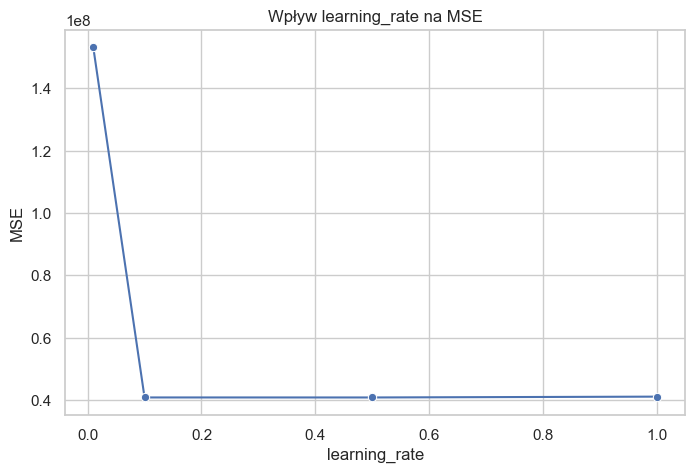

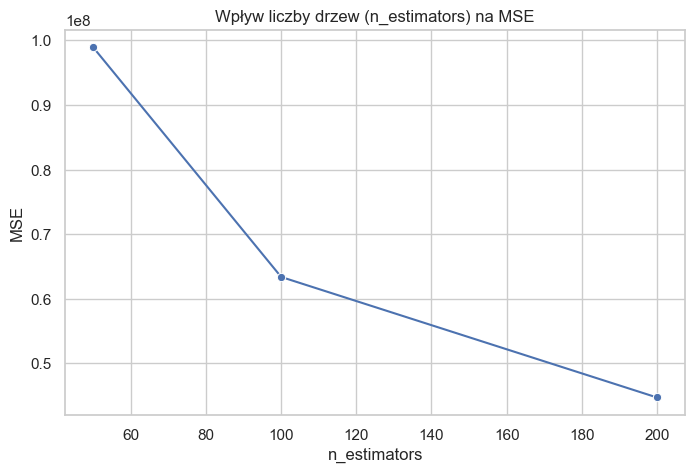

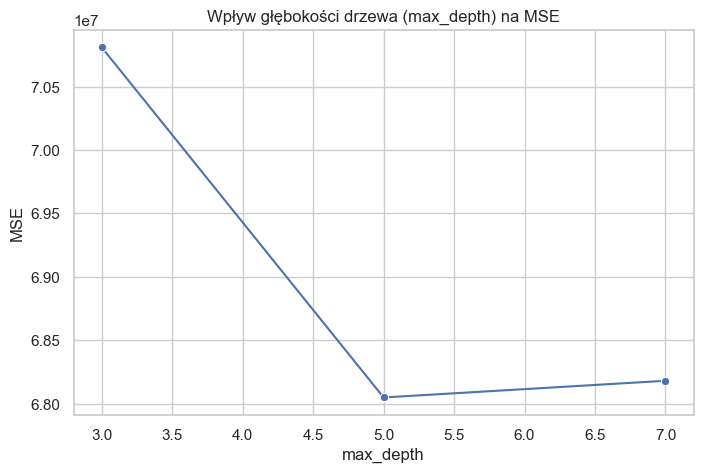

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# learning_rate vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam, x="learning_rate", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na MSE")
plt.xlabel("learning_rate")
plt.ylabel("MSE")
plt.show()

#n_estimators vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam, x="n_estimators", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na MSE")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.show()

#max_depth vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam, x="max_depth", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na MSE")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()


Wniosek: W ogólności zwiększanie parametrów dla tego (bardzo dużego) zbioru danych powoduje otrzymywanie dokładniejszej predykcji.

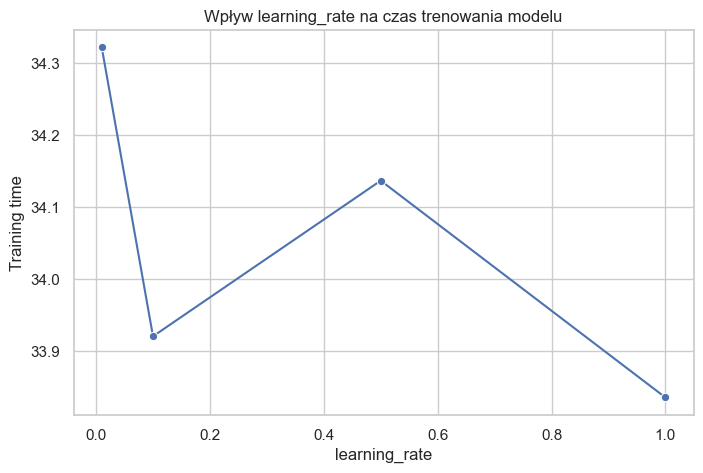

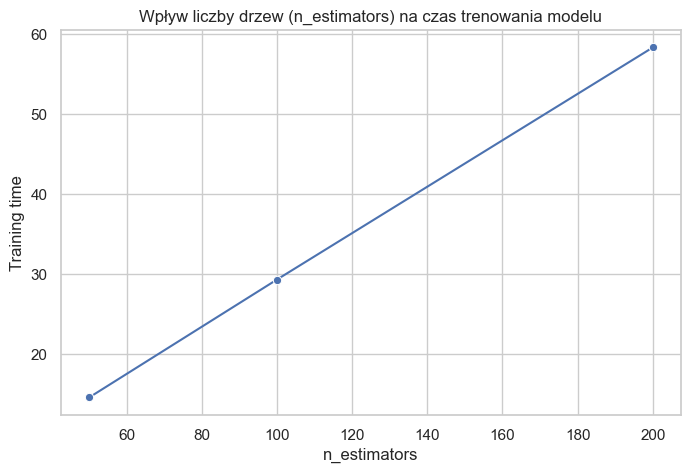

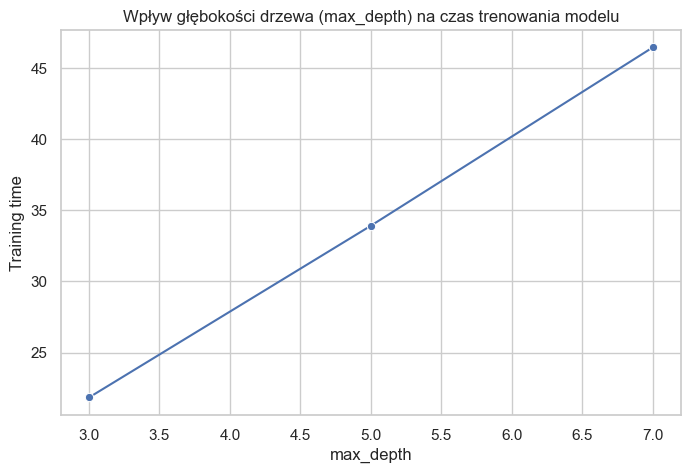

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# learning_rate vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam, x="learning_rate", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na czas trenowania modelu")
plt.xlabel("learning_rate")
plt.ylabel("Training time")
plt.show()

#n_estimators vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam, x="n_estimators", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na czas trenowania modelu")
plt.xlabel("n_estimators")
plt.ylabel("Training time")
plt.show()

#max_depth vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam, x="max_depth", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na czas trenowania modelu")
plt.xlabel("max_depth")
plt.ylabel("Training time")
plt.show()

Wnioski:
1. Czas trenowania modelu jest stosunkowo stabliny, bez względu na parametr learning_rate.
2. Zwiększanie zarówno parametru n_estimators jak i max_depth powoduje liniowy wzrost czasu trenowania modelu.

# AdaBoost

Zbiór danych diabetes

In [91]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = diabetes.data
y = diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.01, 0.2, 0.4, 0.6, 0.8, 1]
n_estimators_list = [10, 50, 90, 130, 170]
max_depths = [1, 2, 3, 4, 5, 6, 7]

results = []

for lr in learning_rates:
    for n_estimators in n_estimators_list:
        for max_depth in max_depths:
            start_time = time.time()

            model = AdaBoostRegressorCust(
                learning_rate=lr,
                n_estimators=n_estimators,
                max_depth=max_depth
            )

            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            start_pred_time = time.time()
            y_pred = model.predict(X_test)
            prediction_time = time.time() - start_pred_time

            mse = mean_squared_error(y_test, y_pred)

            results.append({
                'learning_rate': lr,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'MSE': mse,
                'training_time': training_time,
                'prediction_time': prediction_time
            })

results_diabetes_ada = pd.DataFrame(results)
print(results_diabetes_ada)

     learning_rate  n_estimators  max_depth          MSE  training_time  \
0             0.01            10          1  4604.313538       0.005626   
1             0.01            10          2  3735.090594       0.006287   
2             0.01            10          3  3473.898268       0.007084   
3             0.01            10          4  3405.239588       0.008825   
4             0.01            10          5  3764.689825       0.010830   
..             ...           ...        ...          ...            ...   
205           1.00           170          3  4683.774239       0.113487   
206           1.00           170          4  3167.795579       0.139319   
207           1.00           170          5  2910.867582       0.166257   
208           1.00           170          6  2981.705621       0.188781   
209           1.00           170          7  2971.090214       0.215242   

     prediction_time  
0           0.000857  
1           0.000501  
2           0.000500  
3      

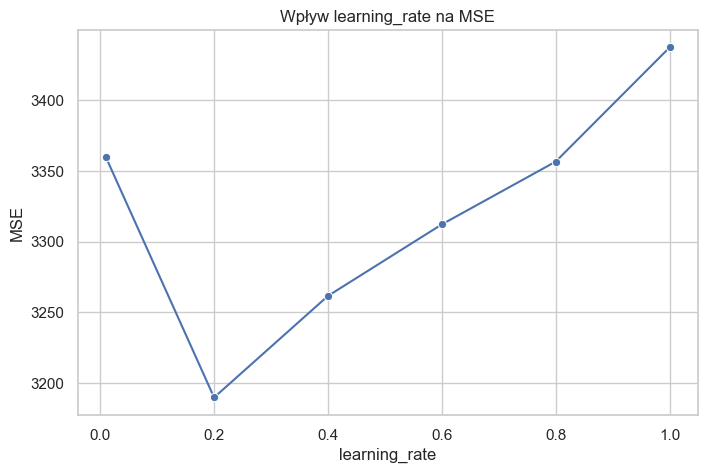

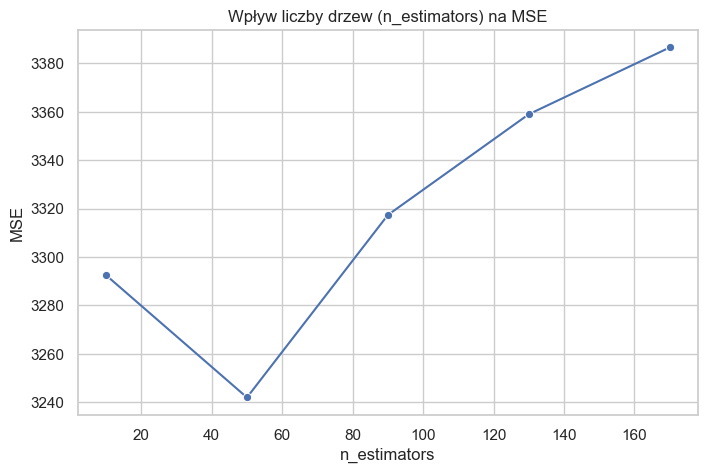

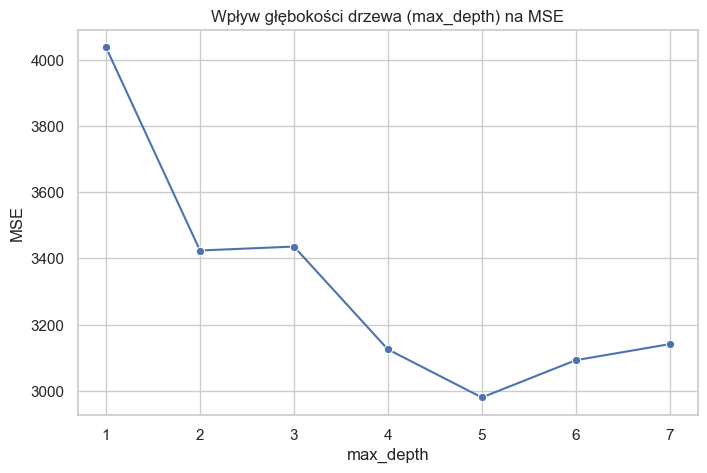

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# learning_rate vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes_ada, x="learning_rate", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na MSE")
plt.xlabel("learning_rate")
plt.ylabel("MSE")
plt.show()

# n_estimators vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes_ada, x="n_estimators", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na MSE")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.show()

# max_depth vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes_ada, x="max_depth", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na MSE")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()

Wnioski:
1. Wysoka wartość MSE (w porównaniu do wartości MSE dla learning_rate=0.2) dla modelu z parametrem learning_rate = 0.01 może świadczyć o tym, że zbyt wolne uczenie się modelu może prowadzić do jego niedouczenia. Najniższa wartość MSE jest osiągana dla modelu z parametrem learning_rate = 0.2. Dalej, wraz ze wzrostem parametru learning_rate wzrasta błąd MSE. Tego powodem może być przeuczanie się modelu, nadmierne dopasowywanie do danych treningowych.
2. Analogiczny wniosek do wniosku 1. można wyciągnąć z analizy wielkości błędu MSE, w zależności od wielkości parametru n_estimators. Najniższy MSE jest osiągany dla wartości n_estimators = 50. Wyższa wartość MSE dla n_estimators=10 może świadczyć o niedouczeniu modelu, natomiast wzrost MSE dla wartości n_estimators większych niż 50 może świadczyć o przeuczeniu modelu.
3. Analizując zależność błędu MSE od parametru max_depth obserwuję stopniowy spadek wartości MSE dla parametru max_depth rosnącego od 1 do 5, zatem dla tego przedziału model będzie się coraz lepiej uczył wraz ze zwiększaniem głębokości drzewa. Dla dalszego wzrostu wartości max_depth MSE wzrasta, co może świadczyć o przeuczaniu się modelu.

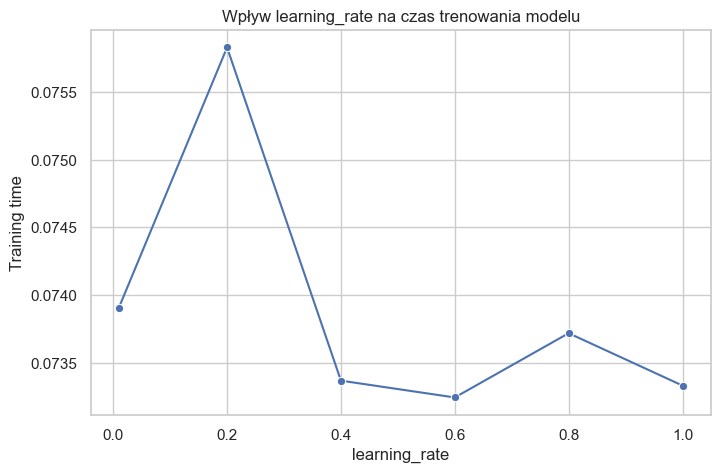

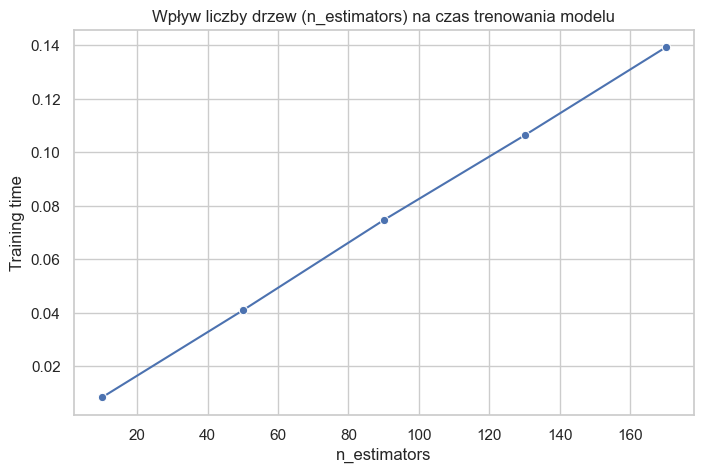

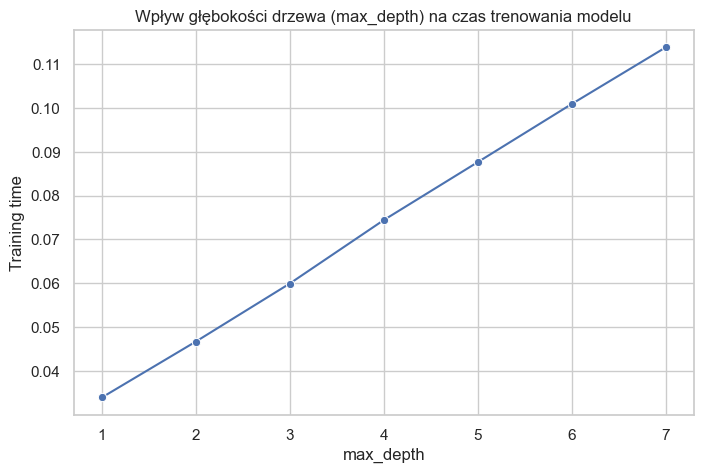

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# learning_rate vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes_ada, x="learning_rate", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na czas trenowania modelu")
plt.xlabel("learning_rate")
plt.ylabel("Training time")
plt.show()

# n_estimators vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes_ada, x="n_estimators", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na czas trenowania modelu")
plt.xlabel("n_estimators")
plt.ylabel("Training time")
plt.show()

# max_depth vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diabetes_ada, x="max_depth", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na czas trenowania modelu")
plt.xlabel("max_depth")
plt.ylabel("Training time")
plt.show()

Wnioski:
1. Czas trenowania modelu jest względnie stabilny dla kolejnych wartości learning_rate. Znaczną różnicę można zauważyć jedynie dla wartości parametru learning_rate = 0.2. Może to być wynikiem konkretnej specyfiki danych, kiedy to przy wartości learning_rate 0.2 model będzie przeprowadzał więcej precyzyjnych obliczeń aby się dopasować do danych, co skutkuje w wydłużeniu czasu trenowania modelu.
2. Zarówno dla parametru max_depth jak i n_estimators czas trenowania modelu rośnie liniowo wraz ze wzrostem owych parametrów.

Zbiór danych wine quality


In [94]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

full_data = wine
X = full_data.drop('quality', axis=1)
y = full_data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.01, 0.2, 0.4, 0.6, 0.8, 1]
n_estimators_list = [10, 50, 90, 130, 170]
max_depths = [1, 2, 3, 4, 5, 6, 7]

results = []

for lr in learning_rates:
    for n_estimators in n_estimators_list:
        for max_depth in max_depths:
            start_time = time.time()

            model = AdaBoostRegressorCust(
                learning_rate=lr,
                n_estimators=n_estimators,
                max_depth=max_depth
            )

            model.fit(X_train, y_train)

            training_time = time.time() - start_time

            start_pred_time = time.time()
            y_pred = model.predict(X_test)
            prediction_time = time.time() - start_pred_time

            mse = mean_squared_error(y_test, y_pred)

            results.append({
                'learning_rate': lr,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'MSE': mse,
                'training_time': training_time,
                'prediction_time': prediction_time
            })

results_wine_ada = pd.DataFrame(results)
print(results_wine_ada)

     learning_rate  n_estimators  max_depth       MSE  training_time  \
0             0.01            10          1  0.649354       0.027263   
1             0.01            10          2  0.601540       0.040917   
2             0.01            10          3  0.572549       0.057945   
3             0.01            10          4  0.550696       0.068325   
4             0.01            10          5  0.541113       0.082023   
..             ...           ...        ...       ...            ...   
205           1.00           170          3  0.663064       0.886554   
206           1.00           170          4  0.942664       1.126102   
207           1.00           170          5  0.507630       1.378775   
208           1.00           170          6  0.478542       1.629979   
209           1.00           170          7  0.445488       1.891605   

     prediction_time  
0           0.002422  
1           0.002484  
2           0.002545  
3           0.002572  
4           0.002538

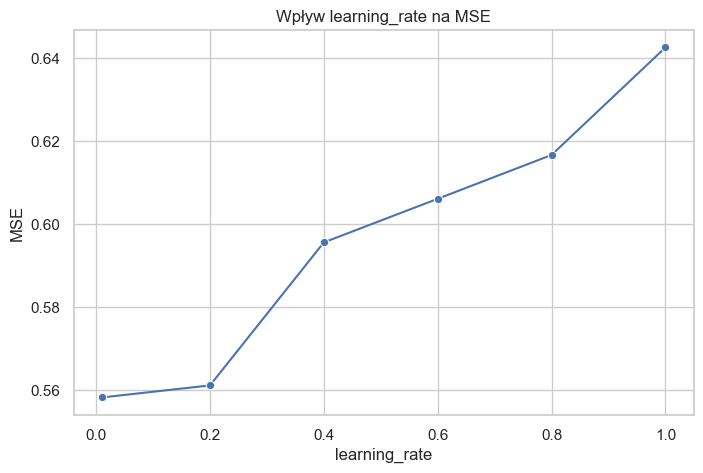

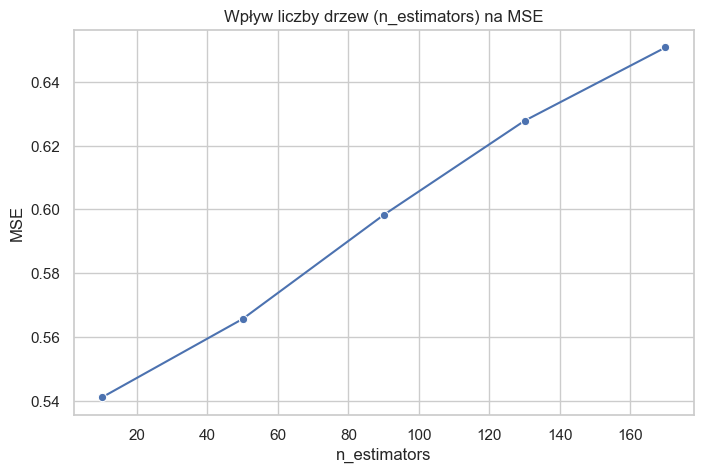

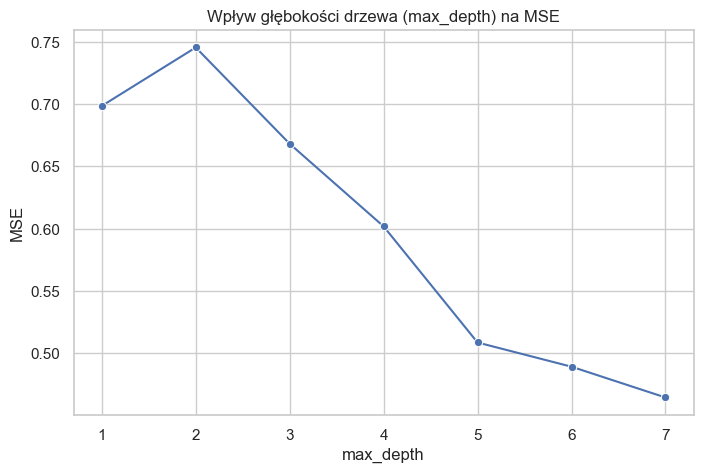

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine_ada, x="learning_rate", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na MSE")
plt.xlabel("learning_rate")
plt.ylabel("MSE")
plt.show()
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine_ada, x="n_estimators", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na MSE")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.show()
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine_ada, x="max_depth", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na MSE")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()

Wnioski:
1. Wraz ze wzrostem learning_rate obserwuję wzrost MSE. Może to być powodem zbyt 'agresywnego' aktualizowania predykcji przez model, natomiast niski learning_rate przy dużym zbiorze danych (wine) pozwala na dokładniejsze uczenie modelu.
2. Wraz ze wzrostem parametru n_estimators MSE rośnie. Może to oznaczać, że model nadmiernie dopasowuje się do analizowanych danych.
3. Zwiększanie głębokości drzewa pozwala na dokładniejsze dopasowanie się do danych, dlatego też wartość MSE zmniejsza się wraz ze wzrostem maksymalnej głębokości drzewa.

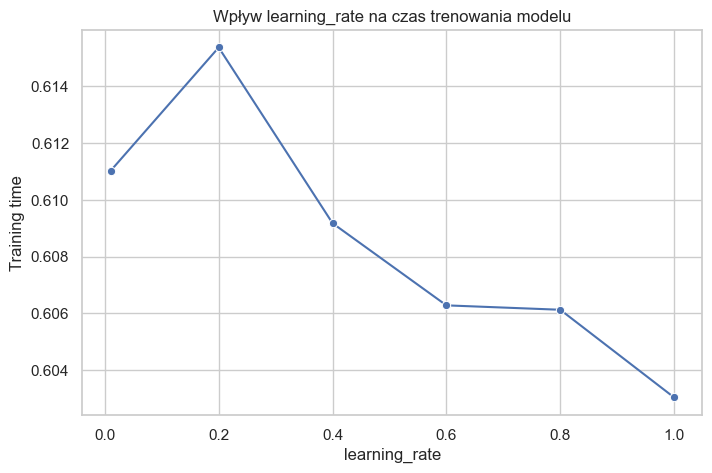

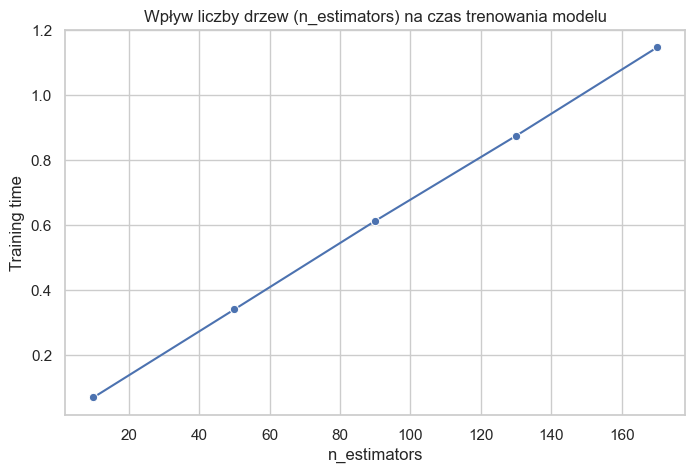

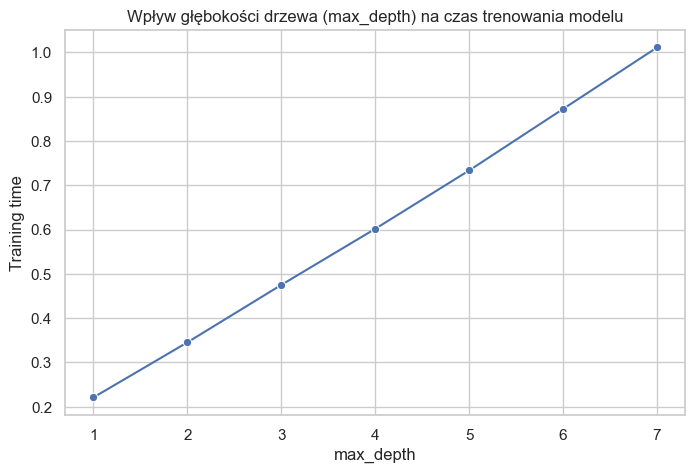

In [96]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine_ada, x="learning_rate", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na czas trenowania modelu")
plt.xlabel("learning_rate")
plt.ylabel("Training time")
plt.show()
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine_ada, x="n_estimators", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na czas trenowania modelu")
plt.xlabel("n_estimators")
plt.ylabel("Training time")
plt.show()
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_wine_ada, x="max_depth", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na czas trenowania modelu")
plt.xlabel("max_depth")
plt.ylabel("Training time")
plt.show()

Wnioski:
1. Czas trenowania modelu maleje wraz ze wzrostem parametru learning_rate (dla wartości większych niż 0.2). Dodatkowo analizując learning_rate vs MSE dla tego damego zbioru danych (i tej samej metody), zauważalnym jest, że dzieje się to kosztem predykcji (MSE zwiększa się, a czas trenowania zmniejsza wraz ze wzrostem learning rate).
2. Zwiększanie parametrów max_depth oraz n_estimators powodują liniowe zwiększanie czasu potrzebnego na trenowanie modelu.

In [104]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

full_data = diam
X = full_data.drop('total_sales_price', axis=1)
X = X.astype(int)
y = full_data['total_sales_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.01, 0.2, 0.4, 0.6, 0.8, 1]
n_estimators_list = [10, 50, 90, 130, 170]
max_depths = [1, 2, 3, 4, 5, 6, 7]

results = []

for lr in learning_rates:
    for n_estimators in n_estimators_list:
        for max_depth in max_depths:
            start_time = time.time()

            model = AdaBoostRegressorCust(
                learning_rate=lr,
                n_estimators=n_estimators,
                max_depth=max_depth
            )

            model.fit(X_train, y_train)

            training_time = time.time() - start_time

            start_pred_time = time.time()
            y_pred = model.predict(X_test)
            prediction_time = time.time() - start_pred_time

            mse = mean_squared_error(y_test, y_pred)

            results.append({
                'learning_rate': lr,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'MSE': mse,
                'training_time': training_time,
                'prediction_time': prediction_time
            })

results_diam_ada = pd.DataFrame(results)
print(results_diam_ada)
import seaborn as sns
import matplotlib.pyplot as plt



     learning_rate  n_estimators  max_depth           MSE  training_time  \
0             0.01            10          1  2.263261e+08       0.884601   
1             0.01            10          2  7.771769e+07       1.465652   
2             0.01            10          3  2.197390e+07       1.894545   
3             0.01            10          4  6.419047e+06       2.415295   
4             0.01            10          5  1.817961e+06       2.933188   
..             ...           ...        ...           ...            ...   
205           1.00           170          3  2.938811e+09      32.172694   
206           1.00           170          4  3.820576e+07      41.295474   
207           1.00           170          5  6.535486e+06      50.234698   
208           1.00           170          6  5.836939e+06      59.062005   
209           1.00           170          7  1.073530e+06      68.107750   

     prediction_time  
0           0.046612  
1           0.045771  
2           0.0416

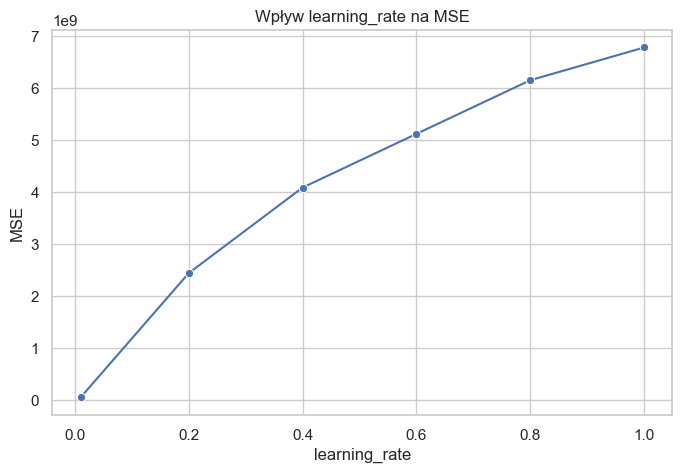

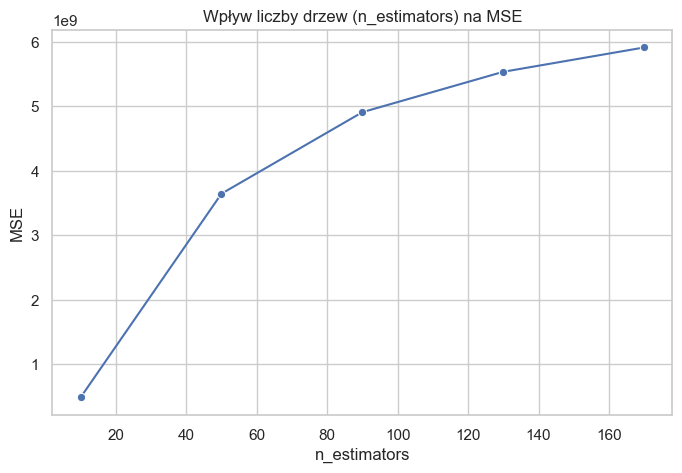

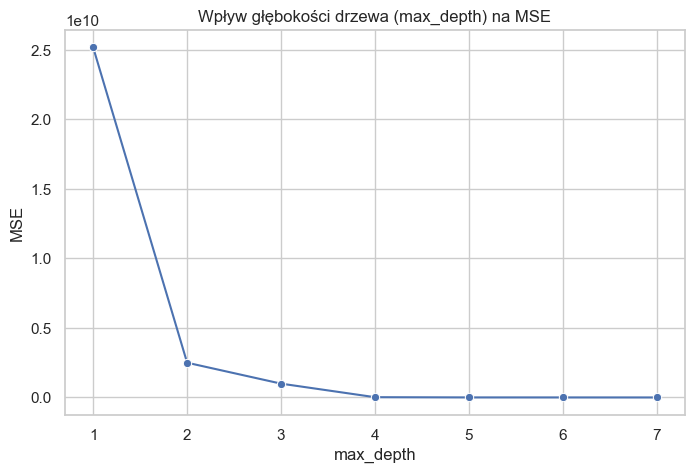

In [105]:
sns.set(style="whitegrid")

# learning_rate vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam_ada, x="learning_rate", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na MSE")
plt.xlabel("learning_rate")
plt.ylabel("MSE")
plt.show()

#n_estimators vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam_ada, x="n_estimators", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na MSE")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.show()

#max_depth vs MSE
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam_ada, x="max_depth", y="MSE", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na MSE")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()


Wnioski (analogiczne do wniosków z analizy zbioru danych wine quality):
1. Wraz ze wzrostem learning_rate obserwuję wzrost MSE. Może to być powodem zbyt 'agresywnego' aktualizowania predykcji przez model, natomiast niski learning_rate przy dużym zbiorze danych (diamonds) pozwala na dokładniejsze uczenie modelu.
2. Wraz ze wzrostem parametru n_estimators MSE rośnie. Może to oznaczać, że model nadmiernie dopasowuje się do analizowanych danych.
3. Zwiększanie głębokości drzewa pozwala na dokładniejsze dopasowanie się do danych, dlatego też wartość MSE zmniejsza się wraz ze wzrostem maksymalnej głębokości drzewa.

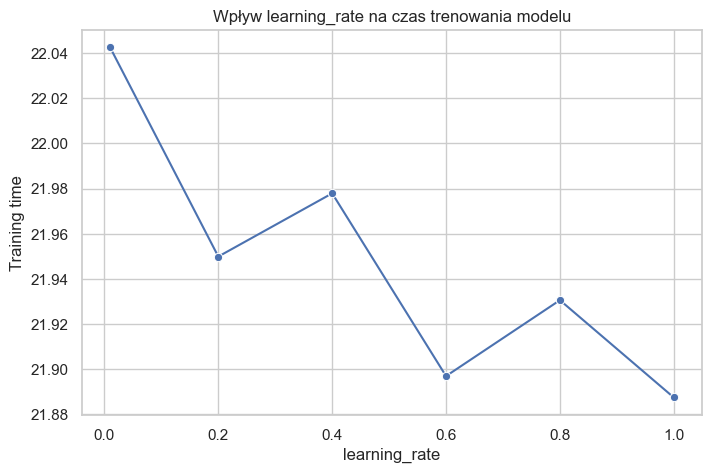

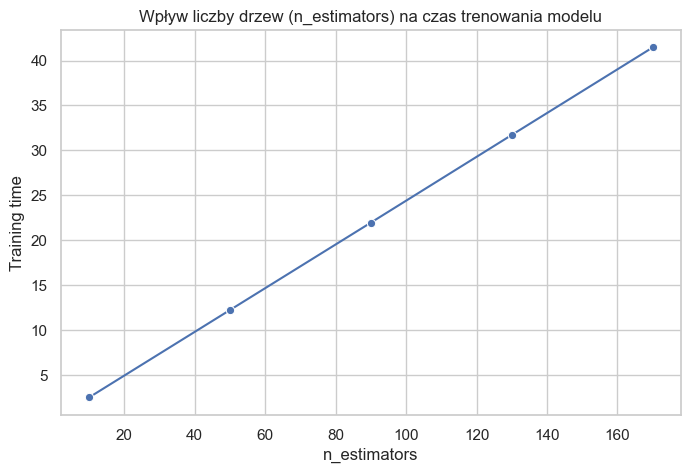

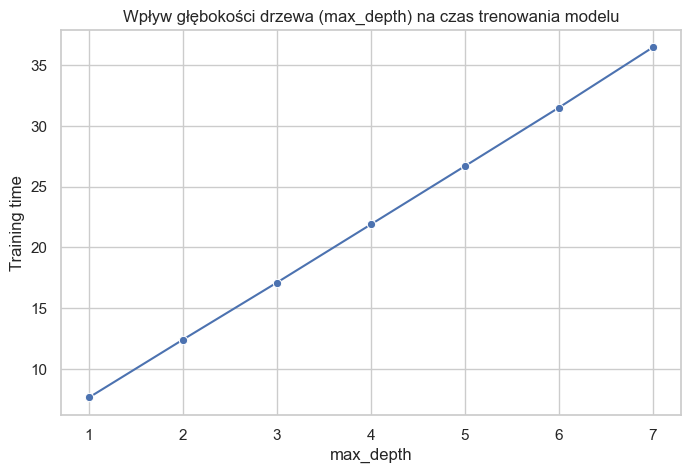

In [106]:
# learning_rate vs time

plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam_ada, x="learning_rate", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ learning_rate na czas trenowania modelu")
plt.xlabel("learning_rate")
plt.ylabel("Training time")
plt.show()

#n_estimators vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam_ada, x="n_estimators", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ liczby drzew (n_estimators) na czas trenowania modelu")
plt.xlabel("n_estimators")
plt.ylabel("Training time")
plt.show()

#max_depth vs time
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_diam_ada, x="max_depth", y="training_time", marker="o", errorbar=None)
plt.title("Wpływ głębokości drzewa (max_depth) na czas trenowania modelu")
plt.xlabel("max_depth")
plt.ylabel("Training time")
plt.show()

Wnioski:
1. Analizując czas trenowania modelu względem rosnącej wartości parametru learning_rate można zauważyć trend spadkowy, jednak w ogólności czas trenowania modelu jest stabilny.
2. Zarówno zwiększenie parametru max_depth, jak i n_estimators, powodują liniowy wzrost czasu trenowania modelu.

## Podsumowanie

Czas trenowania modelu wzrasta liniowo przy zwiększaniu parametrów max_depth jak i n_estimators, natomiast wartość parametru learning_rate ma nieznaczny wpływ na czas trenowania modelu.

Wnioski dotyczące wpływu poszczególnych parametrów na błąd MSE predykcji są różne, w zależności od metody i analizowanego zbioru danych.